In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to set a fixed seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print(f"Random seed set to: {seed}")

set_seed(42)

# Check if GPU is available (Colab usually provides T4 GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Random seed set to: 42
Using device: cuda


In [2]:
# Hyperparameters
BATCH_SIZE = 64

# Simple normalization for Baseline
# We do not add data augmentation (flipping/cropping) yet.
transform_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Downloading CIFAR-10
# We use the official train-test splits
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_baseline)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_baseline)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Define classes for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print("Dataset loaded successfully.")

100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


Dataset loaded successfully.


In [3]:
class SimpleCustomCNN(nn.Module):
    def __init__(self):
        super(SimpleCustomCNN, self).__init__()

        # Block 1: Input 3x32x32 -> Output 32x16x16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: Input 32x16x16 -> Output 64x8x8
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3: Input 64x8x8 -> Output 128x4x4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 256) # 128 channels * 4x4 image size
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10) # Output 10 classes

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model
model = SimpleCustomCNN().to(device)
print("Model initialized.")

Model initialized.


In [4]:
# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
val_accuracies = []

def train_model(model, train_loader, test_loader, epochs=20):
    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        model.train() # Set mode to training
        running_loss = 0.0

        # Training Loop
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Loop (Check accuracy on test set)
        model.eval() # Set mode to evaluation
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_train_loss:.4f} | Test Acc: {val_acc:.2f}%")

    print("Training Finished.")

# Run Training
train_model(model, trainloader, testloader, epochs=15) # 15 Epochs is enough for baseline

Starting training for 15 epochs...
Epoch [1/15] Loss: 1.3949 | Test Acc: 59.83%
Epoch [2/15] Loss: 0.9839 | Test Acc: 68.29%
Epoch [3/15] Loss: 0.7924 | Test Acc: 72.66%
Epoch [4/15] Loss: 0.6610 | Test Acc: 72.97%
Epoch [5/15] Loss: 0.5568 | Test Acc: 73.64%
Epoch [6/15] Loss: 0.4661 | Test Acc: 74.74%
Epoch [7/15] Loss: 0.3855 | Test Acc: 75.18%
Epoch [8/15] Loss: 0.3069 | Test Acc: 74.06%
Epoch [9/15] Loss: 0.2411 | Test Acc: 74.77%
Epoch [10/15] Loss: 0.1988 | Test Acc: 74.37%
Epoch [11/15] Loss: 0.1601 | Test Acc: 74.91%
Epoch [12/15] Loss: 0.1231 | Test Acc: 73.66%
Epoch [13/15] Loss: 0.1089 | Test Acc: 74.54%
Epoch [14/15] Loss: 0.1050 | Test Acc: 74.92%
Epoch [15/15] Loss: 0.0949 | Test Acc: 74.93%
Training Finished.


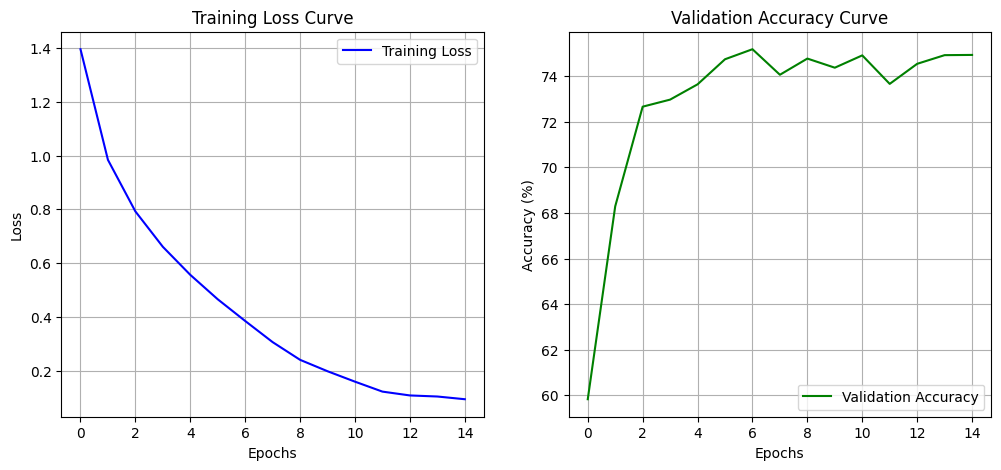

In [5]:
# Plotting the Training Loss and Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

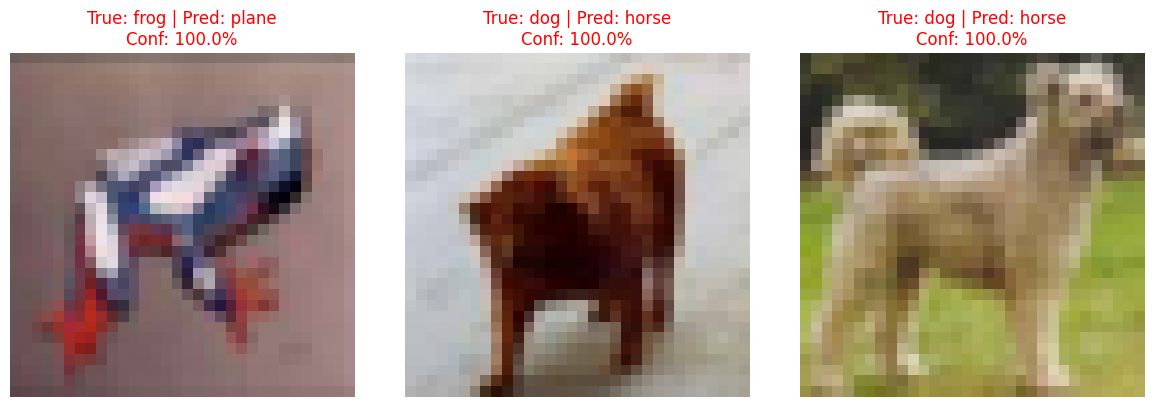

Failure analysis complete. Look at the images above.


In [6]:
import torch.nn.functional as F

def get_confident_failures(model, loader, num_failures=3):
    model.eval() # Set to evaluation mode
    failures = []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Calculate probabilities using Softmax
            probabilities = F.softmax(outputs, dim=1)

            # Get the predicted class and its confidence score
            max_probs, predicted = torch.max(probabilities, 1)

            # Go through the batch
            for i in range(len(labels)):
                # If prediction is WRONG
                if predicted[i] != labels[i]:
                    # Store this failure: (confidence, image, predicted_label, true_label)
                    failures.append({
                        'confidence': max_probs[i].item(),
                        'image': images[i].cpu(),
                        'pred_label': classes[predicted[i]],
                        'true_label': classes[labels[i]]
                    })

    # Sort failures by confidence (highest first) to find "Confident Errors"
    failures.sort(key=lambda x: x['confidence'], reverse=True)

    return failures[:num_failures]

# Function to un-normalize and show image
def imshow_failure(img):
    img = img / 2 + 0.5  # Un-normalize (reverse the (0.5, 0.5) we did earlier)
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)) # Convert from Tensor (C,H,W) to Numpy (H,W,C)

# Run the search
top_failures = get_confident_failures(model, testloader, num_failures=3)

# Plot the 3 images
plt.figure(figsize=(12, 4))
for i, fail in enumerate(top_failures):
    plt.subplot(1, 3, i+1)
    plt.imshow(imshow_failure(fail['image']))
    plt.title(f"True: {fail['true_label']} | Pred: {fail['pred_label']}\nConf: {fail['confidence']*100:.1f}%", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Failure analysis complete. Look at the images above.")

/tmp/ipython-input-3504801070.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


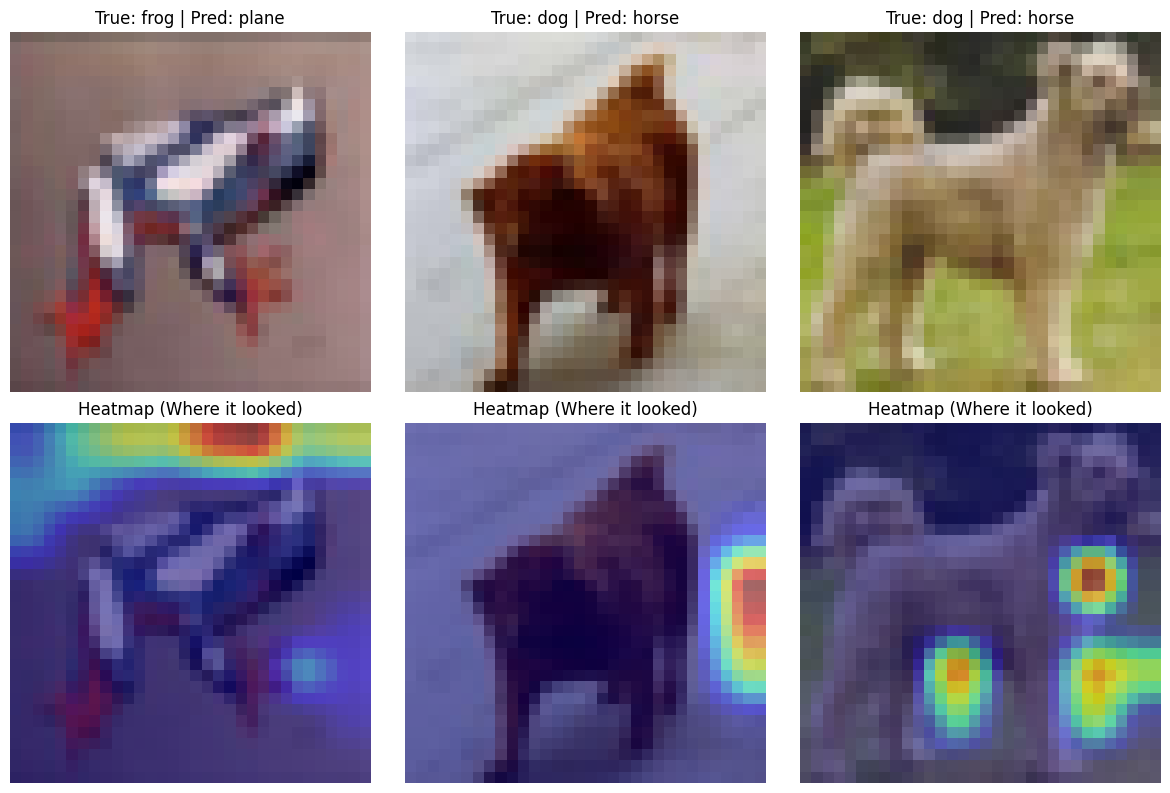

In [7]:
# Variables to store gradients and features
gradients = None
activations = None

# Hook functions to capture data during forward/backward pass
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0] # Save the gradients

def forward_hook(module, input, output):
    global activations
    activations = output # Save the feature map

# Register hooks on the LAST convolutional layer (conv3)
# This is where the model has the "richest" spatial information
hook_backward = model.conv3.register_full_backward_hook(backward_hook)
hook_forward = model.conv3.register_forward_hook(forward_hook)

def generate_heatmap(failures_list):
    plt.figure(figsize=(12, 8))

    for i, fail in enumerate(failures_list):
        img_tensor = fail['image'].unsqueeze(0).to(device) # Add batch dim

        # 1. Forward Pass
        model.eval()
        output = model(img_tensor)

        # 2. Target the *Predicted* Class (where the model was wrong)
        # We want to know: "Why did you think this was X?"
        pred_idx = output.argmax(dim=1)
        score = output[:, pred_idx]

        # 3. Backward Pass (to get gradients)
        model.zero_grad()
        score.backward()

        # 4. Compute Grad-CAM
        # Pool the gradients (Global Average Pooling)
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Weight the channels by the gradients
        # (batch, channels, h, w)
        activation = activations[0]
        for j in range(activation.shape[0]):
            activation[j, :, :] *= pooled_gradients[j]

        # Average the channels to get a single 2D heatmap
        heatmap = torch.mean(activation, dim=0).cpu().detach()

        # Apply ReLU (we only care about positive influence)
        heatmap = np.maximum(heatmap, 0)

        # Normalize heatmap (0 to 1) for plotting
        if torch.max(heatmap) != 0:
            heatmap /= torch.max(heatmap)

        # 5. Plotting
        # Original Image
        ax = plt.subplot(2, 3, i+1)
        original_img = imshow_failure(fail['image'])
        plt.imshow(original_img)
        plt.title(f"True: {fail['true_label']} | Pred: {fail['pred_label']}")
        plt.axis('off')

        # Heatmap Overlay
        ax = plt.subplot(2, 3, i+4)
        plt.imshow(original_img)
        # Resize heatmap to match image size (32x32)
        heatmap = cv2.resize(heatmap.numpy(), (32, 32))
        plt.imshow(heatmap, cmap='jet', alpha=0.5) # Alpha blends it
        plt.title(f"Heatmap (Where it looked)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# We need cv2 for resizing the heatmap smoothly
import cv2

# Run the visualization
try:
    generate_heatmap(top_failures)
except Exception as e:
    print(f"Error generating heatmap: {e}")

# Remove hooks so they don't interfere later
hook_backward.remove()
hook_forward.remove()

In [8]:
print("Starting re-training with Data Augmentation...")

# 1. Define the NEW transform with Augmentation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      # Flip 50% of images
    transforms.RandomCrop(32, padding=4),        # Shift image slightly
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2. Reload the Training Data with these new transforms
trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_augmented)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Note: Test set remains the SAME (No augmentation on test data)
# We want to see if the model learned better on the standard test images.

# 3. Re-initialize the Model (Reset weights to random)
model_aug = SimpleCustomCNN().to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() # Redefine just in case

# Lists for new metrics
aug_train_losses = []
aug_val_accuracies = []

# 4. Train the new model
# We use the same loop structure as before
print(f"Training Augmented Model for 15 epochs...")

for epoch in range(15):
    model_aug.train()
    running_loss = 0.0

    for i, data in enumerate(trainloader_aug, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_aug.zero_grad()
        outputs = model_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_aug.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader_aug)
    aug_train_losses.append(avg_loss)

    # Validation
    model_aug.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model_aug(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    aug_val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/15] Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

print("Augmented Training Finished.")

Starting re-training with Data Augmentation...
Training Augmented Model for 15 epochs...
Epoch [1/15] Loss: 1.5442 | Test Acc: 56.76%
Epoch [2/15] Loss: 1.1553 | Test Acc: 65.41%
Epoch [3/15] Loss: 0.9408 | Test Acc: 70.92%
Epoch [4/15] Loss: 0.8350 | Test Acc: 72.90%
Epoch [5/15] Loss: 0.7653 | Test Acc: 75.66%
Epoch [6/15] Loss: 0.7122 | Test Acc: 76.39%
Epoch [7/15] Loss: 0.6737 | Test Acc: 75.98%
Epoch [8/15] Loss: 0.6409 | Test Acc: 77.57%
Epoch [9/15] Loss: 0.6157 | Test Acc: 78.01%
Epoch [10/15] Loss: 0.5886 | Test Acc: 78.72%
Epoch [11/15] Loss: 0.5717 | Test Acc: 79.30%
Epoch [12/15] Loss: 0.5493 | Test Acc: 80.42%
Epoch [13/15] Loss: 0.5351 | Test Acc: 79.81%
Epoch [14/15] Loss: 0.5176 | Test Acc: 79.67%
Epoch [15/15] Loss: 0.5041 | Test Acc: 79.86%
Augmented Training Finished.


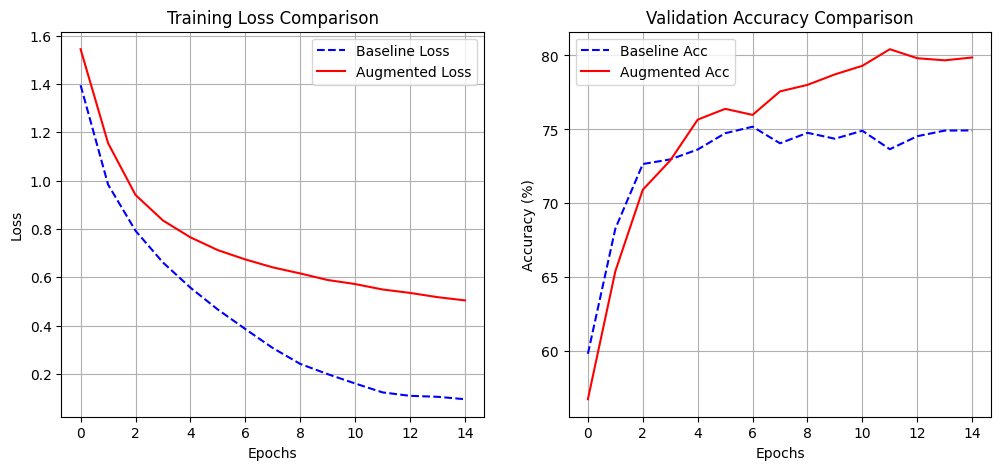

Final Baseline Accuracy: 74.93%
Final Augmented Accuracy: 79.86%
Improvement: +4.93%


In [9]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Baseline Loss', color='blue', linestyle='--')
plt.plot(aug_train_losses, label='Augmented Loss', color='red')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Baseline Acc', color='blue', linestyle='--')
plt.plot(aug_val_accuracies, label='Augmented Acc', color='red')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

print(f"Final Baseline Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Final Augmented Accuracy: {aug_val_accuracies[-1]:.2f}%")
print(f"Improvement: +{aug_val_accuracies[-1] - val_accuracies[-1]:.2f}%")